# 1. Segmentation Clients — Étude RFM

## 1.1 Description du projet

Ce notebook réalise une **analyse de segmentation client** pour un site e-commerce, selon le modèle **RFM (Recency, Frequency, Monetary)**.  
L’objectif est d’identifier des groupes de clients aux comportements d’achat distincts, afin de proposer des actions marketing ciblées (programmes de fidélité, relances, offres personnalisées, etc.).

Les étapes principales sont :

1. Exploration des données (EDA)  
2. Calcul des variables RFM  
3. Standardisation des variables  
4. Segmentation par clustering  
5. Validation du modèle  
6. Interprétation des clusters  
7. Recommandations stratégiques

---

## 1.2 Contexte métier

La segmentation client est un levier essentiel en marketing digital. En catégorisant les clients selon leur valeur et leur engagement, une entreprise peut :

- Mieux cibler ses campagnes marketing  
- Fidéliser les clients stratégiques  
- Optimiser les coûts d’acquisition et de rétention  
- Augmenter la valeur vie client (CLV)

---

## 1.3 Source des données
https://archive.ics.uci.edu/dataset/502/online+retail+ii


# 2. Importation & Préparation des données

In [210]:
# Importation des bibliothèques nécessaires pour l’analyse

import pandas as pd
import matplotlib as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Pour une meilleure lisibilité des chiffres
pd.options.display.float_format="{:20.2f}".format

# Afficher toutes le colonnes
pd.set_option("display.max_columns",999)

# 3. Analyse exploratoire (EDA)

In [211]:
df = pd.read_excel("./Data/online_retail_II.xlsx", sheet_name=0)
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.00,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.00,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.00,United Kingdom


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


Nous constatons qu'il y a moins de "customer ID" que de "Invoice" --> Prévoir une analyse des valeurs nulles

In [213]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.00,525461,525461.00,417534.00
mean,10.34,2010-06-28 11:37:36.845017856,4.69,15360.65
min,-9600.00,2009-12-01 07:45:00,-53594.36,12346.00
25%,1.00,2010-03-21 12:20:00,1.25,13983.00
50%,3.00,2010-07-06 09:51:00,2.10,15311.00
75%,10.00,2010-10-15 12:45:00,4.21,16799.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,107.42,NaN,146.13,1680.81


Les valeurs minimales observées pour Quantity et Price sont négatives. Une analyse complémentaire est nécesaire.

In [214]:
# Pour inclure les données de type object
df.describe(include="O")

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


In [215]:
# Voyons maintenant à quoi correspondent les "Customer ID" vides
df[df["Customer ID"].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


Ces lignes devront être supprimées, car nous ne pouvons pas classifier des clients sans ID.

In [216]:
# Vérifions à quoi correspondent les quantités "négatives"
df[df["Quantity"]<0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321.00,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.00,United Kingdom


Nous observons ici des "invoices" commençant par la lettre “C”. Selon la source des données, cela correspond à des annulations (cancels).

In [217]:
# afficher les factures qui ont plus de 6 digits dans "Invoice"
df["Invoice"] = df["Invoice"].astype("str") #convertir en string
df[df["Invoice"].str.match("^//d{6}$") == False].head(10)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.00,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.00,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.00,United Kingdom


In [218]:
# Serait il possible d'avoir d'autres lettres dans l'ID des "invoices"?
df["Invoice"].str.replace("[0-9]","",regex=True).unique()

array(['', 'C', 'A'], dtype=object)

In [219]:
df[df["Invoice"].str.startswith("A",na=False)]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [220]:
# Vérifions à présent la variable StockCode.
# Selon la description fournie par la source des données, elle doit être composée de 5 chiffres.
# StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
df["StockCode"] = df["StockCode"].astype("str")
df[df["StockCode"].str.match("^\\d{5}$")==False].head(10)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.00,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.00,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.00,United Kingdom
29,489436,84596L,BISCUITS SMALL BOWL LIGHT BLUE,8,2009-12-01 09:06:00,1.25,13078.00,United Kingdom
42,489437,84507B,STRIPES DESIGN MONKEY DOLL,6,2009-12-01 09:08:00,2.55,15362.00,United Kingdom
46,489437,84970S,HANGING HEART ZINC T-LIGHT HOLDER,12,2009-12-01 09:08:00,0.85,15362.00,United Kingdom
61,489438,84031A,CHARLIE+LOLA RED HOT WATER BOTTLE,56,2009-12-01 09:24:00,3.00,18102.00,United Kingdom
62,489438,84031B,CHARLIE LOLA BLUE HOT WATER BOTTLE,56,2009-12-01 09:24:00,3.00,18102.00,United Kingdom


In [221]:
# Certains "StockCode" se terminent par des lettres. Vérifions si d'autres types de "StockCode" exitent
df[(df["StockCode"].str.match("^\\d{5}$")==False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$")==False)]["StockCode"].unique()

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

D’après la documentation source, ces StockCode sont non valides ; nous les exclurons de l’analyse.

## 3.1 Nettoyage des données

In [222]:
cleaned_df=df.copy()
cleaned_df["Invoice"] = cleaned_df["Invoice"].astype("str")
# Conserver uniquement les lignes avec des "Invoices" valides
cleaned_df=cleaned_df[cleaned_df["Invoice"].str.match("^\\d{6}$")==True]

In [223]:
# Conserver uniquement les lignes avec des codes "StockCode" valides
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype("str")
cleaned_df=cleaned_df[(cleaned_df["StockCode"].str.match("^\\d{5}$")==True) | (cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$")==True)]

In [224]:
# Supprimer les lignes avec des "Customer ID" vides
cleaned_df=cleaned_df.dropna(subset=["Customer ID"])

In [225]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406323.00,406323,406323.00,406323.00
mean,13.62,2010-07-01 10:14:46.649094656,2.99,15373.66
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14004.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.37


In [226]:
# Certaines lignes ont des prix = 0
# nous allons les retirer du dataset
cleaned_df=cleaned_df[cleaned_df["Price"]>0]
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406295.00,406295,406295.00,406295.00
mean,13.62,2010-07-01 10:18:05.997415424,2.99,15373.75
min,1.00,2009-12-01 07:45:00,0.03,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14006.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.33


In [227]:
# Calculons maintenant la proportion des données conservées après le nettoyage
len(cleaned_df)/len(df)

0.7732162805612596

77 % des données initiales ont été conservées (soit 23 % des données supprimées au cours du nettoyage)

# 4. Feature Engineering (construction des variables de segmentation)

Pour analyser le comportement des clients, nous allons construire trois indicateurs couramment utilisés dans les modèles de segmentation marketing.  
Ces variables correspondent au modèle **RFM** : *Recency*, *Frequency* et *Monetary*.

- **Recency (Récence)** : représente le nombre de jours écoulés depuis le dernier achat du client. Une récence faible indique un client encore actif.  
- **Frequency (Fréquence)** : correspond au nombre total d’achats effectués par le client sur une période donnée. Elle traduit son niveau d’engagement et de fidélité.  
- **Monetary (Montant dépensé)** : mesure la somme totale des dépenses réalisées par le client, permettant d’identifier les profils à forte valeur.

L’analyse conjointe de ces trois dimensions permet de mieux comprendre les comportements d’achat et de construire une segmentation pertinente, utile pour orienter les actions marketing telles que la fidélisation, la relance ou la personnalisation des offres.


In [228]:
# Calculer le montant total dépensé par client
cleaned_df["totalSales"]=cleaned_df["Quantity"] * cleaned_df["Price"]
# Mesurer le temps écoulé depuis le dernier achat
max_invoice_date = cleaned_df["InvoiceDate"].max()
max_invoice_date
cleaned_df["Recency"] = (max_invoice_date - cleaned_df["InvoiceDate"]).dt.days
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,totalSales,Recency
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40,373
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00,373
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00,373
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80,373
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00,373
...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom,5.90,0
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75,0
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75,0
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,7.50,0


In [229]:
# Grouper les données par client
grouped_df=cleaned_df.groupby(by="Customer ID", as_index=False).agg(
Monetary = ("totalSales","sum"),
Frequency = ("Invoice","nunique"),
Recency=("Recency","min")

)
grouped_df.head(10)

,Customer ID,Monetary,Frequency,Recency
0,12346.00,169.36,2,164
1,12347.00,1323.32,2,2
2,12348.00,221.16,1,73
3,12349.00,2221.14,2,42
4,12351.00,300.93,1,10
5,12352.00,343.80,2,10
6,12353.00,317.76,1,43
7,12355.00,488.21,1,202
8,12356.00,3126.25,3,15
9,12357.00,11229.99,1,23


## 4.1 Analyse graphique

Text(0, 0.5, 'Nombre')

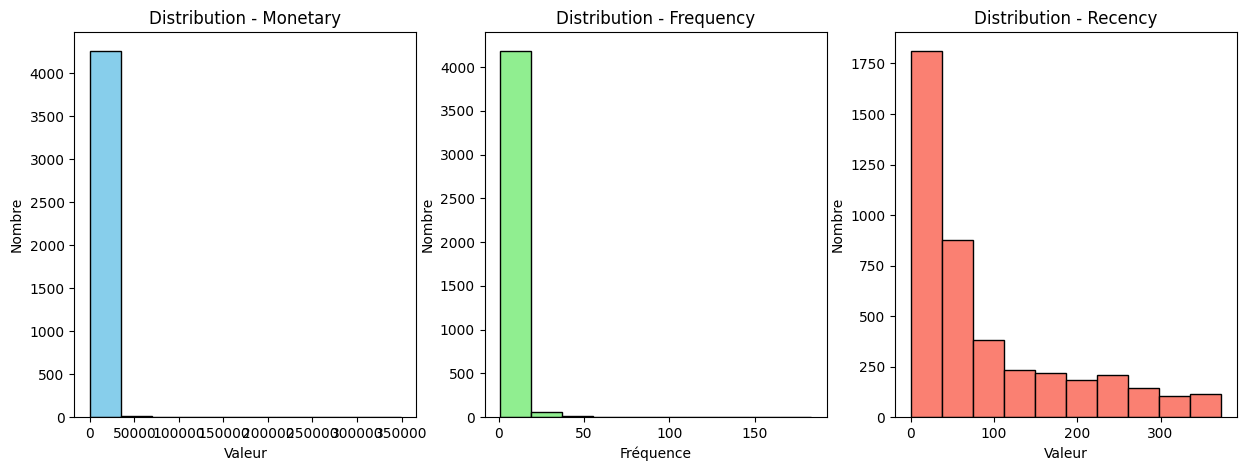

In [230]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(grouped_df["Monetary"], bins=10, color = "skyblue", edgecolor="black")
plt.title("Distribution - Monetary")
plt.xlabel("Valeur")
plt.ylabel("Nombre")

plt.subplot(1, 3, 2)
plt.hist(grouped_df["Frequency"], bins=10, color = "lightgreen", edgecolor="black")
plt.title("Distribution - Frequency")
plt.xlabel("Fréquence")
plt.ylabel("Nombre")


plt.subplot(1, 3, 3)
plt.hist(grouped_df["Recency"], bins=10, color = "salmon", edgecolor="black")
plt.title("Distribution - Recency")
plt.xlabel("Valeur")
plt.ylabel("Nombre")



Pour une meilleure visualisation des outliers (les valeurs extrêmes), nous allons utiliser les Boxplot. 

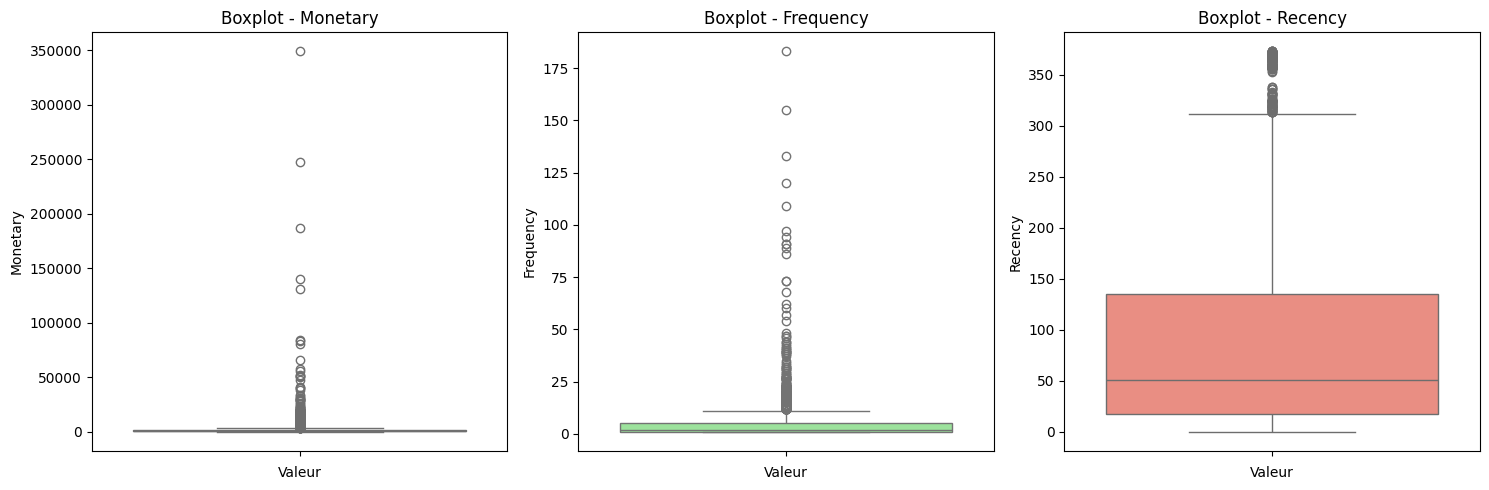

In [250]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=grouped_df["Monetary"], color='skyblue')
plt.title("Boxplot - Monetary")
plt.xlabel("Valeur")

plt.subplot(1, 3, 2)
sns.boxplot(data=grouped_df["Frequency"], color='lightgreen')
plt.title("Boxplot - Frequency")
plt.xlabel("Valeur")

plt.subplot(1, 3, 3)
sns.boxplot(data=grouped_df["Recency"], color='salmon')
plt.title("Boxplot - Recency")
plt.xlabel("Valeur")

plt.tight_layout()
plt.show()

### 4.1.1 Analyse des distributions — Variables Monetary, Frequency et Recency

Pour les variables **Monetary** et **Frequency**, nous constatons que les valeurs extrêmes (*outliers*) sont très élevées par rapport aux valeurs dites nominales.  
Ces observations sont importantes, car ces outliers correspondent généralement à des clients à forte valeur :  

- Ceux qui génèrent un chiffre d’affaires élevé,  
- Ou ceux qui achètent très fréquemment.  

Il n’est donc pas pertinent de les exclure de l’analyse, car ils représentent une part stratégique de la clientèle et apportent une valeur significative à l’entreprise.  

Afin d’obtenir une analyse plus pertinente, nous allons adopter une stratégie en **deux étapes** :  

1. Effectuer une première segmentation basée sur les clients *“nominales”*.  
2. Réaliser une seconde segmentation spécifique aux clients identifiés comme *outliers*.  

Cette approche permettra de mieux différencier les comportements et d’obtenir des **insights** plus précis pour chaque groupe de clients.


## 4.2 Séparer les outilers des clients "nominaux"

### 4.2.1 Monetary Outliers

In [251]:
# commençons par récupérer le 25 ème percentile de la variable "Monetary"
M_Q1 = grouped_df["Monetary"].quantile(0.25)
# Ensuite, le 75 ème percentile
M_Q3 = grouped_df["Monetary"].quantile(0.75)
# calculons maintenant l'écart interquartile
M_IQR = M_Q3 - M_Q1

# Créons maintenant le dataset des outliers
monetary_outliers_df = grouped_df[(grouped_df["Monetary"] > (M_Q3 + 1.5 * M_IQR)) | (grouped_df["Monetary"] < (M_Q1 - 1.5 * M_IQR))].copy()

monetary_outliers_df.describe()


,Customer ID,Monetary,Frequency,Recency
count,423.00,423.00,423.00,423.00
mean,15103.04,12188.10,17.17,30.04
std,1728.66,25830.85,19.73,51.54
min,12357.00,3802.04,1.00,0.00
25%,13622.00,4605.94,8.00,3.00
50%,14961.00,6191.32,12.00,13.00
75%,16692.00,10273.24,18.00,31.00
max,18260.00,349164.35,183.00,364.00


## 4.2.2 Frequency Outliers

In [233]:

F_Q1 = grouped_df["Frequency"].quantile(0.25)
F_Q3 = grouped_df["Frequency"].quantile(0.75)
F_IQR = F_Q3 - F_Q1

# Récupérer les outliers
frequency_outliers_df = grouped_df[(grouped_df["Frequency"] > (F_Q3 + 1.5 * F_IQR)) | (grouped_df["Frequency"] < (F_Q1 - 1.5 * F_IQR))].copy()

frequency_outliers_df.describe()



,Customer ID,Monetary,Frequency,Recency
count,279.00,279.00,279.00,279.00
mean,15352.66,14409.71,23.81,16.09
std,1748.43,31381.74,21.93,26.59
min,12437.00,1094.39,12.00,0.00
25%,13800.00,4331.56,13.00,2.00
50%,15465.00,6615.77,17.00,7.00
75%,16828.50,11692.41,23.00,19.00
max,18260.00,349164.35,183.00,211.00


In [254]:
# Création du dataset des clients "nominaux"
cas_nominaux_df = grouped_df[(~ grouped_df.index.isin(monetary_outliers_df.index) & (~ grouped_df.index.isin(frequency_outliers_df.index) ))]
cas_nominaux_df.describe()

,Customer ID,Monetary,Frequency,Recency
count,3809.00,3809.00,3809.00,3809.00
mean,15376.48,885.50,2.86,97.08
std,1693.20,817.67,2.24,98.11
min,12346.00,1.55,1.00,0.00
25%,13912.00,279.91,1.00,22.00
50%,15389.00,588.05,2.00,58.00
75%,16854.00,1269.05,4.00,154.00
max,18287.00,3788.21,11.00,373.00


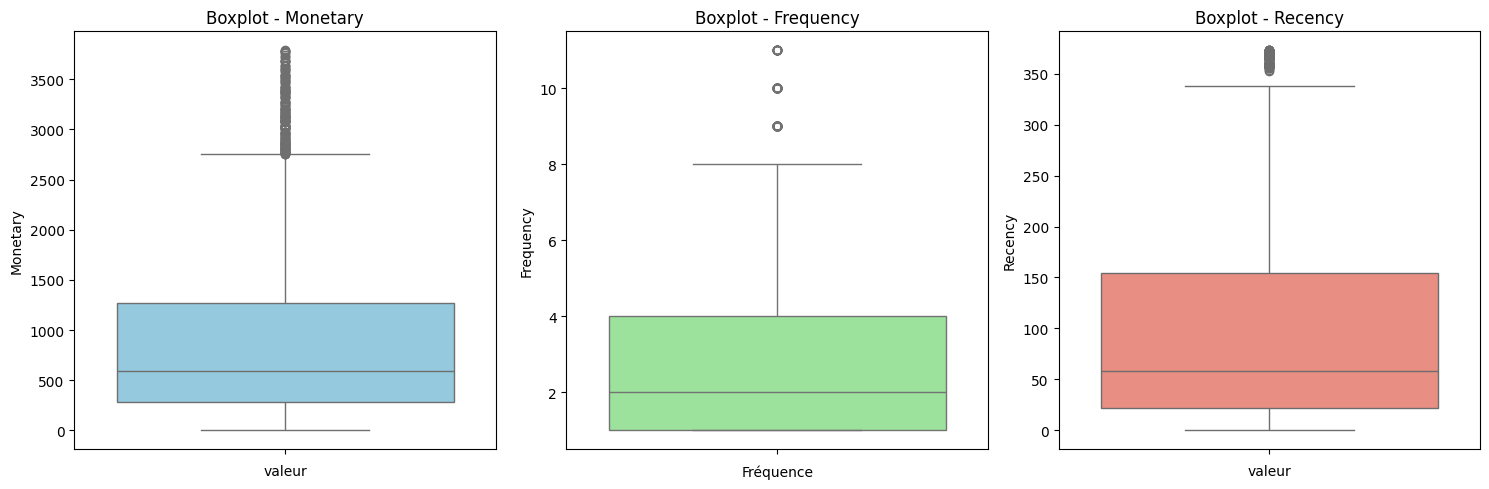

In [235]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=cas_nominaux_df["Monetary"], color='skyblue')
plt.title("Boxplot - Monetary")
plt.xlabel("valeur")

plt.subplot(1, 3, 2)
sns.boxplot(data=cas_nominaux_df["Frequency"], color='lightgreen')
plt.title("Boxplot - Frequency")
plt.xlabel("Fréquence")

plt.subplot(1, 3, 3)
sns.boxplot(data=cas_nominaux_df["Recency"], color='salmon')
plt.title("Boxplot - Recency")
plt.xlabel("valeur")

plt.tight_layout()
plt.show()

Il reste encore des "outliers" mais les données sont beaucoup plus homogènes qu'avant.

# Visualisation 3D
Une visualisation en 3D offre une meilleure compréhension de la distribution des données.

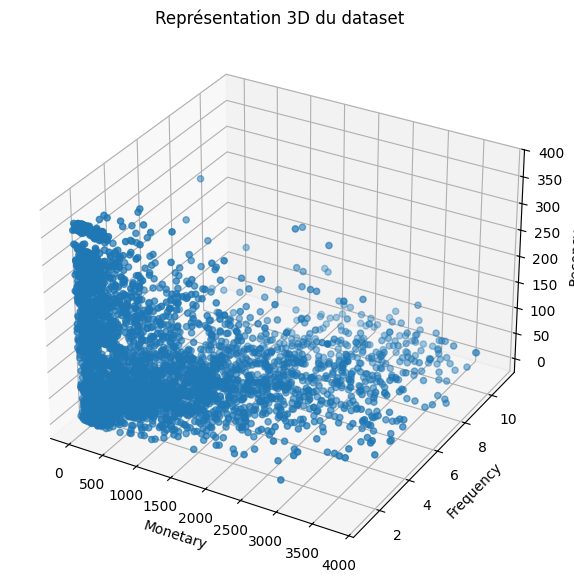

In [236]:

fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(cas_nominaux_df["Monetary"], cas_nominaux_df["Frequency"], cas_nominaux_df["Recency"])

ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('Représentation 3D du dataset')

plt.show()

# 5. Normalisation des données
A la visualisation du graphique 3D, nous pouvons facilement remarquer que les variables **Monetary**, **Frequency** et **Recency** présentent des distributions non uniformes. Cette hétérogénéité peut influencer à la fois la visualisation et l’algorithme de segmentation que nous souhaitons utiliser (K-means clustering). Il est donc nécessaire de normaliser les données avant de poursuivre l’analyse.

In [237]:

scaler = StandardScaler()

scaled_data = scaler.fit_transform(cas_nominaux_df[["Monetary", "Frequency", "Recency"]])

scaled_data

array([[-0.87594534, -0.38488934,  0.68214853],
       [ 0.53551441, -0.38488934, -0.96925093],
       [-0.81258645, -0.83063076, -0.24548944],
       ...,
       [-0.62197163, -0.83063076,  2.01753946],
       [ 0.44146683, -0.38488934,  0.14187587],
       [ 1.72488782,  0.50659348, -0.81634357]])

In [238]:
# convertir nos données normalisées en dataframe
scaled_data_df = pd.DataFrame(scaled_data,index=cas_nominaux_df.index, columns=("Monetary","Frequency","Recency"))
scaled_data_df


,Monetary,Frequency,Recency
0,-0.88,-0.38,0.68
1,0.54,-0.38,-0.97
2,-0.81,-0.83,-0.25
3,1.63,-0.38,-0.56
4,-0.72,-0.83,-0.89
...,...,...,...
4280,-0.30,1.40,-0.82
4281,-0.58,-0.83,-0.32
4282,-0.62,-0.83,2.02
4283,0.44,-0.38,0.14


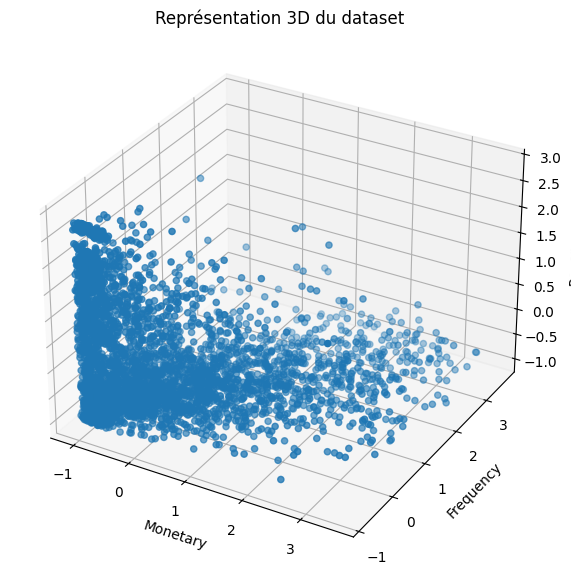

In [ ]:
# regénérer le graphique 3D avec les données normalisées

fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df["Monetary"], scaled_data_df["Frequency"], scaled_data_df["Recency"])

ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('Représentation 3D du dataset')

plt.show()

In [240]:
scaled_data_df.describe()

,Monetary,Frequency,Recency
count,3809.00,3809.00,3809.00
mean,0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-1.08,-0.83,-0.99
25%,-0.74,-0.83,-0.77
50%,-0.36,-0.38,-0.40
75%,0.47,0.51,0.58
max,3.55,3.63,2.81


# 6. Segmentation des clients (K-Means)

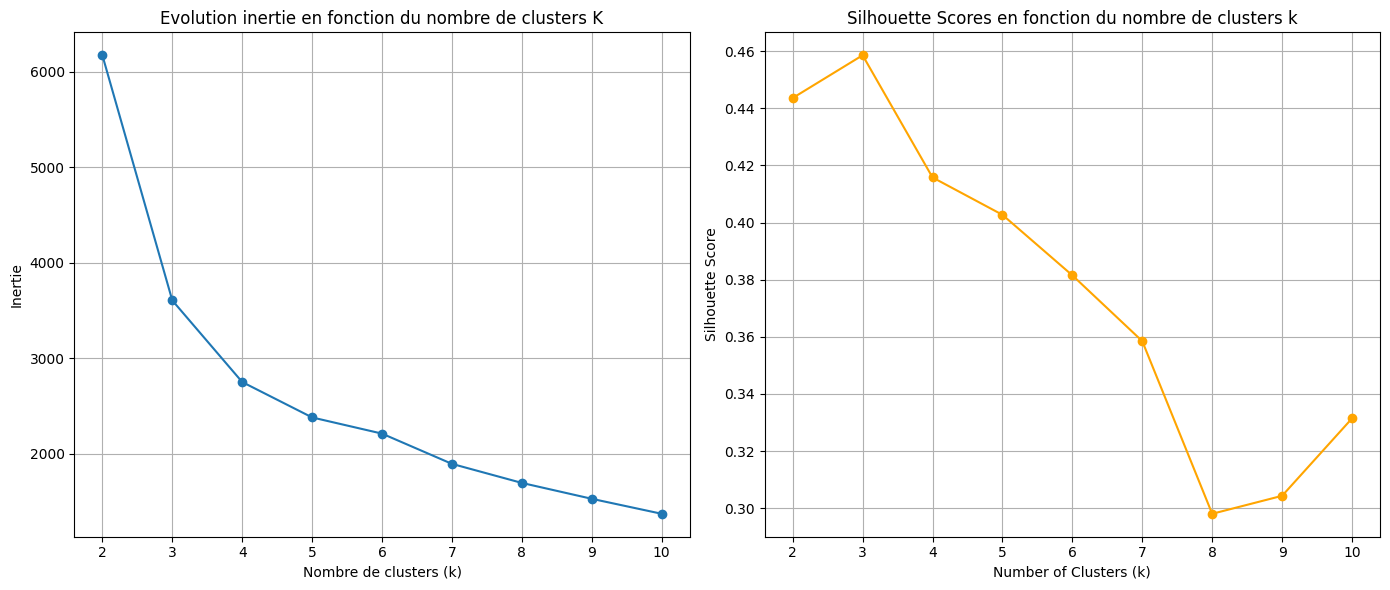

In [241]:
import warnings

# Ignorer les warnings de calcul flottant
warnings.filterwarnings("ignore", category=RuntimeWarning)

max_k = 10
inertie = []
silhoutte_scores = []

k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)

    cluster_labels = kmeans.fit_predict(scaled_data_df)

    sil_score = silhouette_score(scaled_data_df, cluster_labels)

    silhoutte_scores.append(sil_score)

    inertie.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertie, marker='o')
plt.title('Evolution inertie en fonction du nombre de clusters K')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores en fonction du nombre de clusters k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

## 6.1 Analyse

L’évolution de l’inertie suggère qu’un partitionnement en 4 ou 5 clusters serait approprié.  
Cependant, la segmentation en 4 groupes apparaît plus pertinente, car elle présente un score de silhouette supérieur à celui obtenu avec 5 clusters.  

Nous allons donc retenir une segmentation en 4 clusters.


## 6.2 Création des clusters

In [242]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data_df)

cluster_labels

array([1, 0, 2, ..., 1, 0, 0], dtype=int32)

In [243]:
cas_nominaux_df["Cluster"] = cluster_labels

cas_nominaux_df

/var/folders/r5/w2l3nv355gq1bbfwnmb045680000gn/T/ipykernel_60501/3668277105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cas_nominaux_df["Cluster"] = cluster_labels


,Customer ID,Monetary,Frequency,Recency,Cluster
0,12346.00,169.36,2,164,1
1,12347.00,1323.32,2,2,0
2,12348.00,221.16,1,73,2
3,12349.00,2221.14,2,42,0
4,12351.00,300.93,1,10,2
...,...,...,...,...,...
4280,18283.00,641.77,6,17,0
4281,18284.00,411.68,1,66,2
4282,18285.00,377.00,1,295,1
4283,18286.00,1246.43,2,111,0


## 6.3 Visualisation des clusters

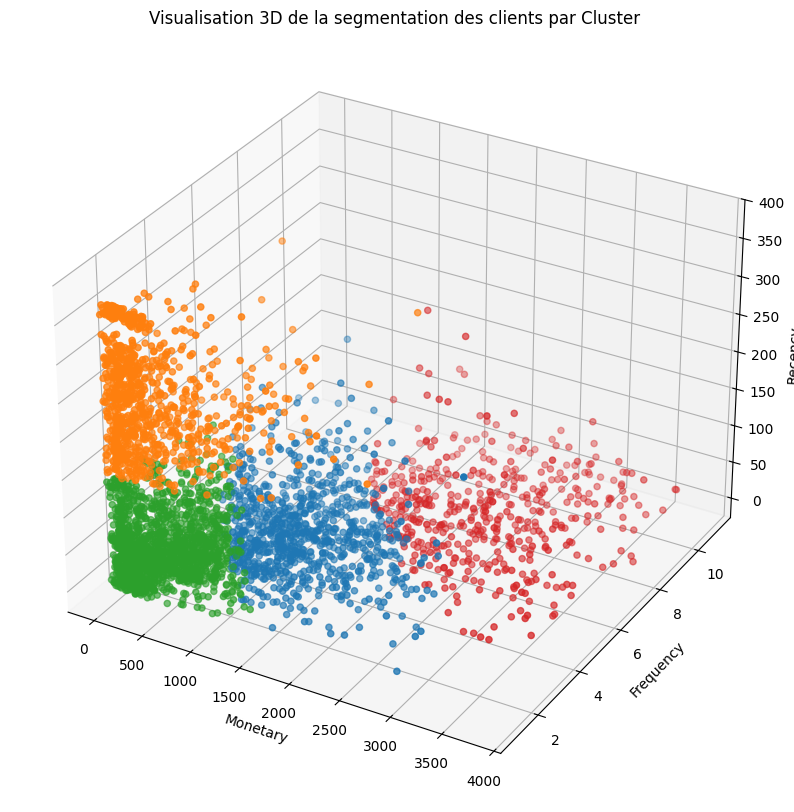

In [244]:
cluster_colors = {0: '#1f77b4',  
                  1: '#ff7f0e',  
                  2: '#2ca02c',  
                  3: '#d62728'}  

colors = cas_nominaux_df["Cluster"].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(cas_nominaux_df["Monetary"], 
                     cas_nominaux_df["Frequency"], 
                     cas_nominaux_df["Recency"], 
                     c=colors,  
                     marker='o')

ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('Visualisation 3D de la segmentation des clients par Cluster')

plt.show()

## 6.4 Première interprétation

Nous pouvons distinguer clairement les 4 clusters sur cette visualisation :

1. **Cluster rouge**  
   - Fréquence d'achat élevée  
   - Dépenses (Monetary) élevées  
   - Achats récents  

2. **Cluster bleu**  
   - Fréquence d'achat moyenne  
   - Dépenses moyennes  
   - Achats récents  

3. **Cluster vert**  
   - Faible fréquence d'achat  
   - Dépenses faibles  
   - Achats récents  

4. **Cluster orange**  
   - Fréquence d'achat faible à moyenne  
   - Dépenses faibles  
   - Recency élevée → les derniers achats remontent à plusieurs mois


Pour approfondir l’analyse, nous allons utiliser des diagrammes en violon (violin plots) afin de comparer la distribution de chaque cluster avec la distribution globale des trois variables : Frequency, Monetary et Recency.

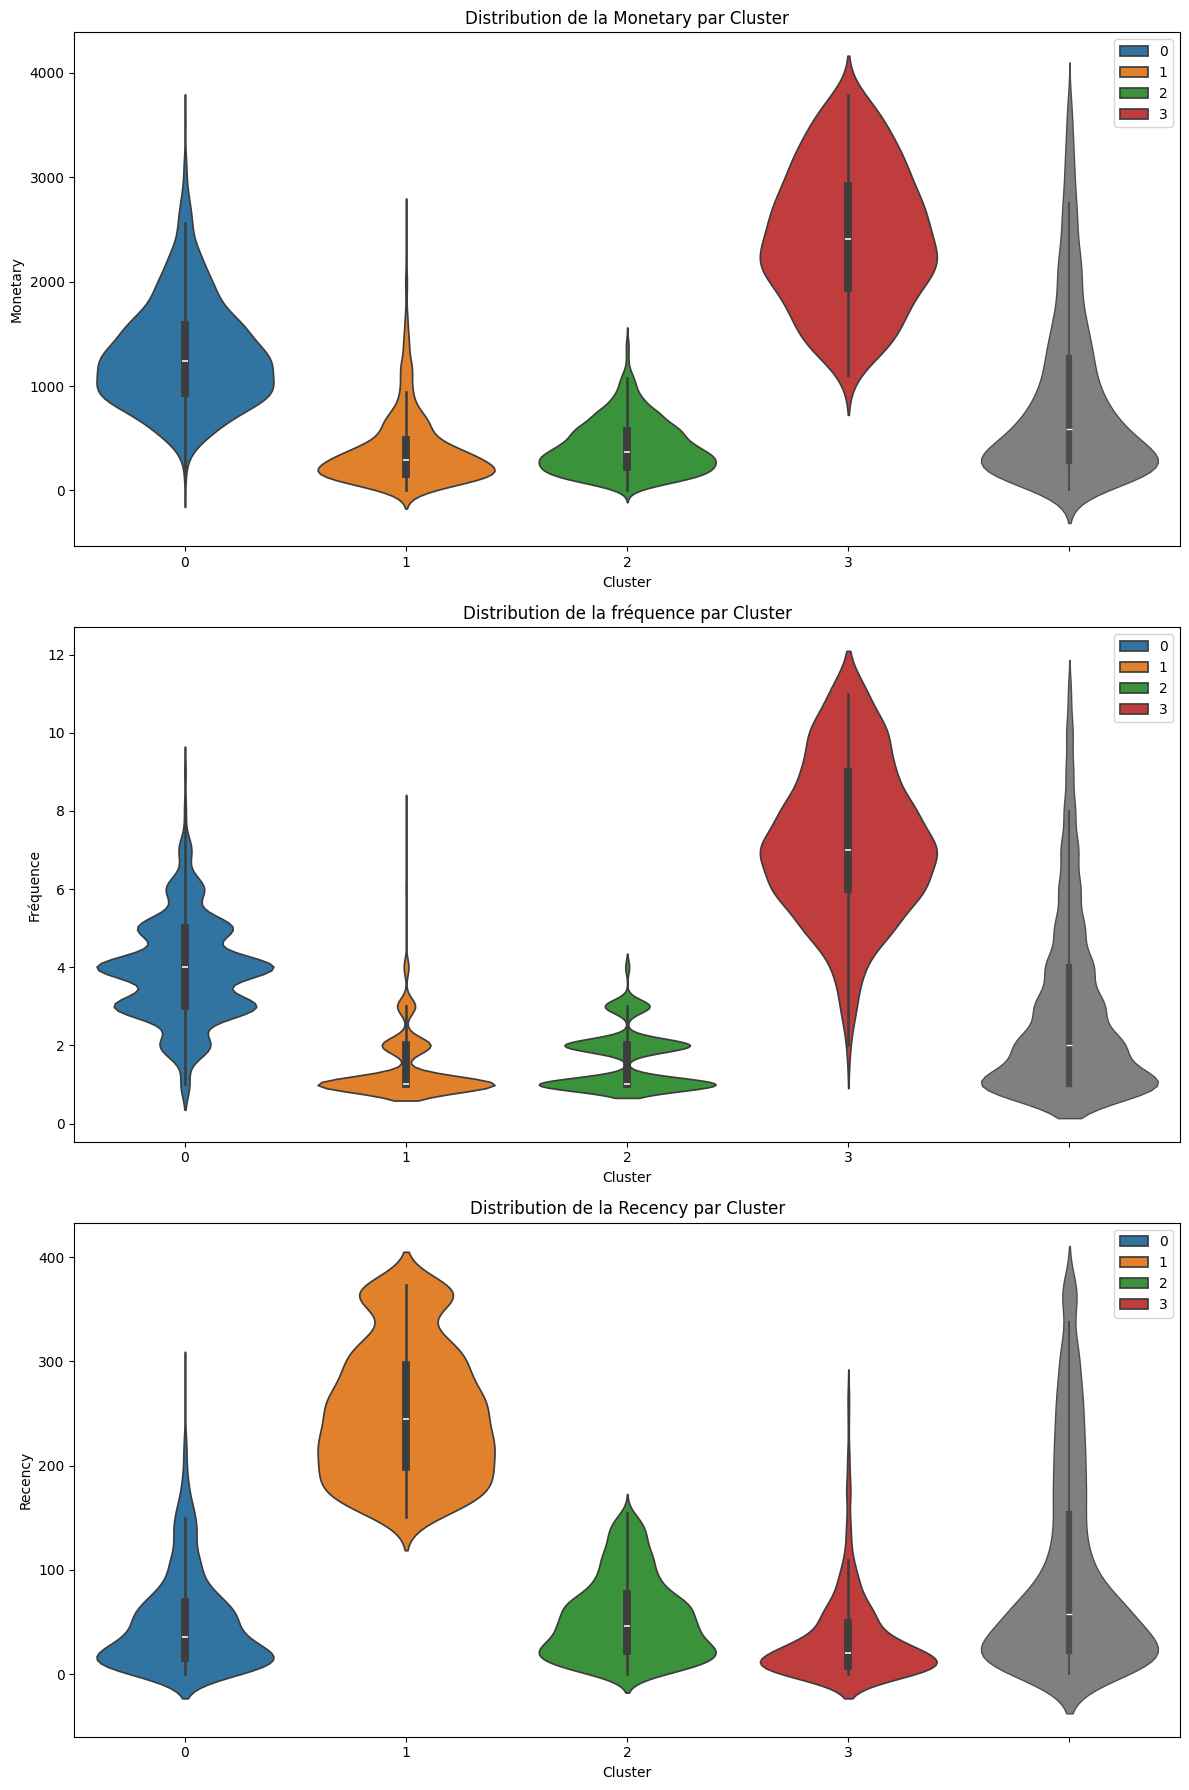

In [245]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=cas_nominaux_df['Cluster'], y=cas_nominaux_df['Monetary'], palette=cluster_colors, hue=cas_nominaux_df["Cluster"])
sns.violinplot(y=cas_nominaux_df['Monetary'], color='gray', linewidth=1.0)
plt.title('Distribution de la Monetary par Cluster')
plt.ylabel('Monetary')

plt.subplot(3, 1, 2)
sns.violinplot(x=cas_nominaux_df['Cluster'], y=cas_nominaux_df['Frequency'], palette=cluster_colors, hue=cas_nominaux_df["Cluster"])
sns.violinplot(y=cas_nominaux_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Distribution de la fréquence par Cluster')
plt.ylabel('Fréquence')


plt.subplot(3, 1, 3)
sns.violinplot(x=cas_nominaux_df['Cluster'], y=cas_nominaux_df['Recency'], palette=cluster_colors, hue=cas_nominaux_df["Cluster"])
sns.violinplot(y=cas_nominaux_df['Recency'], color='gray', linewidth=1.0)
plt.title('Distribution de la Recency par Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

## 6.5 Recommandations marketing
### **Cluster Bleu : “Retenir”**  
**Justification :** Ce cluster regroupe des clients à forte valeur, qui achètent régulièrement, même si leurs achats ne sont pas toujours très récents. L’objectif principal est de mettre en place des actions de rétention afin de maintenir leur fidélité et leur niveau de dépenses.  
**Action :** Mettre en place des programmes de fidélité, des offres personnalisées et un engagement régulier pour s’assurer qu’ils restent actifs.

---

### **Cluster Orange : “Réengager”**  
**Justification :** Ce groupe comprend des clients à faible valeur, effectuant peu d’achats et n’ayant pas acheté récemment. L’objectif est de les réengager pour retrouver un comportement d’achat actif.  
**Action :** Utiliser des campagnes marketing ciblées, des promotions spéciales ou des rappels pour les encourager à revenir et effectuer de nouveaux achats.

---

### **Cluster Vert : “Développer”**  
**Justification :** Ce cluster regroupe les clients les moins actifs et de plus faible valeur, mais qui ont effectué des achats récents. Il peut s’agir de nouveaux clients ou de clients nécessitant un accompagnement pour augmenter leur engagement et leurs dépenses.  
**Action :** Se concentrer sur la création de relation, offrir un excellent service client et proposer des incitations pour encourager des achats plus fréquents.

---

### **Cluster Rouge : “Récompenser”**  
**Justification :** Ce cluster regroupe des clients à forte valeur, réalisant des achats très fréquents et souvent encore actifs. Ce sont vos clients les plus fidèles, et il est essentiel de récompenser leur engagement pour le maintenir.  
**Action :** Mettre en place un programme de fidélité solide, offrir des avantages exclusifs et reconnaître leur fidélité pour les garder engagés et satisfaits.


# 7. Analyse des "Outliers"

In [246]:
# identifier les clients qui se retrouvent dans les deux groupes "Monetary-outlisers" et "Frequency_outliers"
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

# créer 3 groupes spécifiques
monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]

# créer 3 clusters selon les 3 cas possibles
monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

# regouper les données ouliers dans un dataset
outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

outlier_clusters_df

,Customer ID,Monetary,Frequency,Recency,Cluster
9,12357.00,11229.99,1,23,-1
25,12380.00,4782.84,4,100,-1
42,12409.00,12346.62,4,55,-1
48,12415.00,19468.84,4,10,-1
61,12431.00,4145.52,11,8,-1
...,...,...,...,...,...
4235,18223.00,7516.31,12,22,-3
4236,18225.00,7545.14,15,0,-3
4237,18226.00,6650.83,15,13,-3
4241,18231.00,4791.80,23,41,-3


Nous allons utiliser les diagrammes en violon pour l'analyse

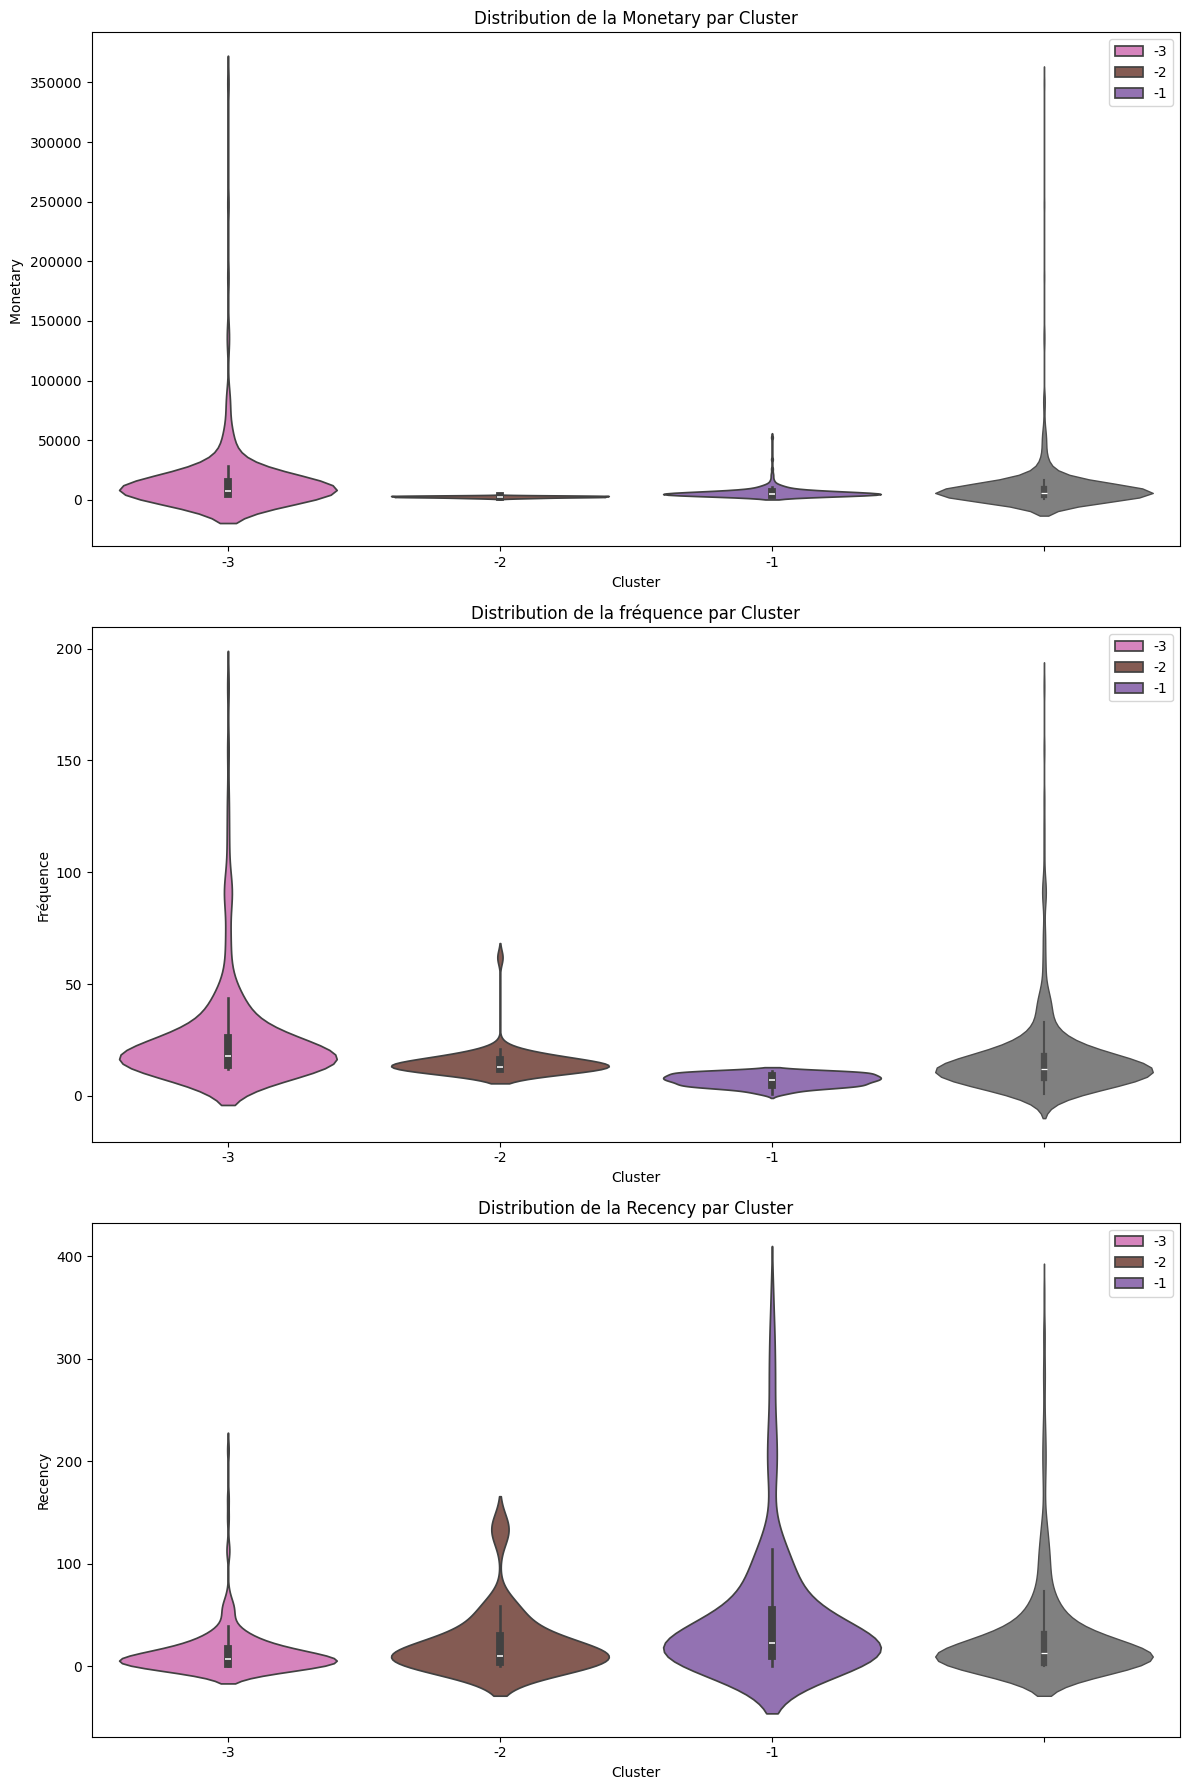

In [247]:
cluster_colors = {-1: '#9467bd',
                  -2: '#8c564b',
                  -3: '#e377c2'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Monetary'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Monetary'], color='gray', linewidth=1.0)
plt.title('Distribution de la Monetary par Cluster')
plt.ylabel('Monetary ')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Distribution de la fréquence par Cluster')
plt.ylabel('Fréquence')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Distribution de la Recency par Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

# 7.1 Recommandations marketing

### **Cluster -1 (Outliers sur le critère Monetary) : “Choyer”**  
**Caractéristiques :** Clients dépensant beaucoup, mais pas nécessairement de manière fréquente. Leurs achats sont importants en montant, mais rares.  
**Stratégie potentielle :** Se concentrer sur le maintien de leur fidélité grâce à des offres personnalisées ou des services premium adaptés à leur forte capacité de dépense.

---

### **Cluster -2 (Outliers sur le critère Frequency) : “Augmenter le panier”**  
**Caractéristiques :** Clients achetant très fréquemment, mais dépensant peu à chaque achat. Ils sont régulièrement engagés, mais pourraient tirer profit d’opportunités d’upsell.  
**Stratégie potentielle :** Mettre en place des programmes de fidélité ou des offres groupées afin d’encourager une dépense plus élevée à chaque visite, compte tenu de leur forte fréquence d’achat.

---

### **Cluster -3 (Outliers sur Monetary & Frequency) : “Enchanter”**  
**Caractéristiques :** Les clients les plus précieux parmi les outliers, combinant dépenses très élevées et achats très fréquents. Il s’agit probablement de vos clients les plus prestigieux, nécessitant une attention particulière.  
**Stratégie potentielle :** Développer des programmes VIP ou des offres exclusives pour maintenir leur fidélité et encourager la poursuite de leur engagement.


# 8. Segmentation finale
Nous allons maintenant regrouper toutes les données dans un seul dataset avec les clusters associés


In [248]:
segmentation_df = pd.concat([cas_nominaux_df, outlier_clusters_df])

segmentation_df


,Customer ID,Monetary,Frequency,Recency,Cluster
0,12346.00,169.36,2,164,1
1,12347.00,1323.32,2,2,0
2,12348.00,221.16,1,73,2
3,12349.00,2221.14,2,42,0
4,12351.00,300.93,1,10,2
...,...,...,...,...,...
4235,18223.00,7516.31,12,22,-3
4236,18225.00,7545.14,15,0,-3
4237,18226.00,6650.83,15,13,-3
4241,18231.00,4791.80,23,41,-3


Nous pouvons également ajouter des étiquettes pour chaque cluster pour une meilleure lisibilité.

In [249]:
# création des labels
cluster_labels = {
    0: "Retenir",
    1: "Réengager",
    2: "Développer",
    3: "Récompenser",
    -1: "Choyer",
    -2: "Augmenter le panier",
    -3: "Enchanter"
}
segmentation_df["ClusterLabel"] = segmentation_df["Cluster"].map(cluster_labels)

segmentation_df

,Customer ID,Monetary,Frequency,Recency,Cluster,ClusterLabel
0,12346.00,169.36,2,164,1,Réengager
1,12347.00,1323.32,2,2,0,Retenir
2,12348.00,221.16,1,73,2,Développer
3,12349.00,2221.14,2,42,0,Retenir
4,12351.00,300.93,1,10,2,Développer
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,22,-3,Enchanter
4236,18225.00,7545.14,15,0,-3,Enchanter
4237,18226.00,6650.83,15,13,-3,Enchanter
4241,18231.00,4791.80,23,41,-3,Enchanter
